In [18]:
import os
import sys
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial.transform import Rotation as R

# --- Path Setup ---
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

from config import CONFIG

# --- Directories ---
DERIV_04 = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_04_filtering")
DERIV_05 = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_05_reference")
os.makedirs(DERIV_05, exist_ok=True)

# --- Anthropometric Check (Non-Blocking) ---
SUBJECT_HEIGHT = CONFIG.get('subject_height_cm')
SUBJECT_MASS = CONFIG.get('subject_mass_kg')

if SUBJECT_HEIGHT is None or SUBJECT_MASS is None:
    print("ℹ️  Note: Height/Mass missing. Focusing on Kinematic Analysis (Angles/Coordination).")
else:
    print(f"✅ Subject Stats loaded: {SUBJECT_HEIGHT}cm, {SUBJECT_MASS}kg")

# --- Load Data ---
csv_filename = Path(CONFIG['current_csv']).stem
RUN_ID = csv_filename
INPUT_FILE = Path(DERIV_04) / f"{RUN_ID}__filtered.parquet"

if not INPUT_FILE.exists():
    raise FileNotFoundError(f"Missing filtered data! Did you run notebook 04?")

df = pd.read_parquet(INPUT_FILE)

# --- Load Kinematics Map (Crucial for Skeleton Structure) ---
km_path = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_02_preprocess", f"{RUN_ID}__kinematics_map.json")

if os.path.exists(km_path):
    with open(km_path, 'r') as f:
        kinematics_map = json.load(f)
    print(f"✅ Kinematics Map Loaded.")
else:
    # כאן אנחנו חייבים לעצור, כי בלי מפה אי אפשר לדעת מהן הזוויות
    raise FileNotFoundError(f"❌ ERROR: Kinematics map missing at {km_path}. Skeleton definition is required.")

print(f"✅ Loaded Filtered Data: {RUN_ID}")

ℹ️  Note: Height/Mass missing. Focusing on Kinematic Analysis (Angles/Coordination).
✅ Kinematics Map Loaded.
✅ Loaded Filtered Data: 734_T1_P1_R1_Take 2025-12-01 02.18.27 PM


In [19]:
# --- CELL 02: Automated Reference Frame Detection ---
# SCIENTIFIC RATIONALE: Biomechanical scaling requires a quasi-static 
# reference period. This algorithm identifies the most stable T-pose 
# based on postural stability metrics (Cappozzo et al., 1995).

def find_optimal_reference_window(df, search_limit_sec=10.0, window_sec=1.5):
    """
    RATIONALE: Scans for the most stable T-Pose. Stability is defined as 
    minimal variance in position and orientation (Winter, 2009).
    """
    fs = CONFIG.get('fs_target', 120.0)
    search_frames = int(search_limit_sec * fs)
    window_frames = int(window_sec * fs)
    
    # Identify key biomechanical columns
    hips_p_cols = [c for c in df.columns if 'Hips__p' in c]
    hips_q_cols = [c for c in df.columns if 'Hips__q' in c]
    l_hand_cols = [c for c in df.columns if any(x in c for x in ['L_Hand__p', 'LeftHand__p'])]
    r_hand_cols = [c for c in df.columns if any(x in c for x in ['R_Hand__p', 'RightHand__p'])]
    
    # --- Unit Detection (Critical for Scaling) ---
    sample_val = abs(df[hips_p_cols[0]].iloc[0])
    is_mm = sample_val > 10.0 
    unit_label = "mm" if is_mm else "m"
    t_pose_thresh = 800.0 if is_mm else 0.8 # 80cm minimum span (Standard adult)
    
    best_start_idx = 0
    min_score = float('inf')
    best_metrics = {}

    print(f"🔍 Unit Detection: Data identified in {unit_label.upper()}")

    for start in range(0, min(len(df), search_frames) - window_frames, 5):
        win = df.iloc[start : start + window_frames]
        
        # 1. Linear Stability (Mean Euclidean Variance)
        pos_std = np.sqrt(win[hips_p_cols].var().mean()) 
        
        # 2. Angular Stability (Euler Jitter in Degrees)
        quats = win[hips_q_cols].values
        euler_angles = R.from_quat(quats).as_euler('xyz', degrees=True)
        ang_std = np.std(euler_angles, axis=0).mean()
        
        # 3. Posture Validation (Symmetry & Span)
        t_pose_penalty = 1.0
        if l_hand_cols and r_hand_cols:
            l_mean = win[l_hand_cols].mean().values
            r_mean = win[r_hand_cols].mean().values
            h_mean = win[hips_p_cols].mean().values
            
            hand_dist = np.linalg.norm(l_mean - r_mean)
            dist_l = np.linalg.norm(l_mean - h_mean)
            dist_r = np.linalg.norm(r_mean - h_mean)
            sym_error = abs(dist_l - dist_r)
            
            # Penalize if not in T-Pose or highly asymmetrical
            if hand_dist < t_pose_thresh: t_pose_penalty += 20.0
            if sym_error > (150.0 if is_mm else 0.15): t_pose_penalty += 5.0

        # Score calculation: Minimal sway + Correct posture
        current_score = (pos_std + ang_std) * t_pose_penalty
        
        if current_score < min_score:
            min_score = current_score
            best_start_idx = start
            best_metrics = {
                "ref_stability_raw": float(pos_std),
                "ref_angular_std_deg": float(ang_std),
                "hand_dist_raw": float(hand_dist),
                "sym_error_raw": float(sym_error),
                "is_mm": is_mm
            }
            
    res_win = df.iloc[best_start_idx : best_start_idx + window_frames]
    
    # Format metrics for Report Audit
    metrics = {
        "start_idx": best_start_idx,
        "ref_df": res_win,
        "stability_mm": best_metrics['ref_stability_raw'] if is_mm else best_metrics['ref_stability_raw']*1000,
        "angular_std_deg": best_metrics['ref_angular_std_deg'],
        "hand_dist_cm": (best_metrics['hand_dist_raw'] / 10) if is_mm else (best_metrics['hand_dist_raw'] * 100),
        "sym_error_cm": (best_metrics['sym_error_raw'] / 10) if is_mm else (best_metrics['sym_error_raw'] * 100),
    }
    
    # Grading for Methodology Section
    if metrics['stability_mm'] < 2.5 and metrics['angular_std_deg'] < 1.0:
        metrics['grade'] = "HIGH"
    elif metrics['stability_mm'] < 6.0:
        metrics['grade'] = "MEDIUM"
    else:
        metrics['grade'] = "LOW"
        
    return metrics

# Run optimized search
res = find_optimal_reference_window(df)
print(f"\n🎯 Reference Window: {res['start_idx']/120:.2f}s | Grade: {res['grade']}")
print(f"\n" + "="*50)
print(f"🔬 BIOMECHANICAL REFERENCE AUDIT: {RUN_ID}")
print(f"="*50)
print(f"⏱️  Temporal Location:  {res['start_idx']/120:.2f} seconds")
print(f"🏅 Confidence Grade:  {res['grade']}")
print(f"---")
print(f"📍 Linear Stability:  {res['stability_mm']:.2f} mm (Limit: < 5mm)")
print(f"📐 Angular Sway:      {res['angular_std_deg']:.2f}° (Limit: < 2°)")
print(f"📏 Arm Span:          {res['hand_dist_cm']:.1f} cm (Target: ~{SUBJECT_HEIGHT} cm)")
print(f"⚖️  Symmetry Offset:   {res['sym_error_cm']:.2f} cm")
print(f"="*50 + "\n")

🔍 Unit Detection: Data identified in MM

🎯 Reference Window: 1.12s | Grade: HIGH

🔬 BIOMECHANICAL REFERENCE AUDIT: 734_T1_P1_R1_Take 2025-12-01 02.18.27 PM
⏱️  Temporal Location:  1.12 seconds
🏅 Confidence Grade:  HIGH
---
📍 Linear Stability:  0.82 mm (Limit: < 5mm)
📐 Angular Sway:      0.44° (Limit: < 2°)
📏 Arm Span:          114.0 cm (Target: ~None cm)
⚖️  Symmetry Offset:   1.58 cm



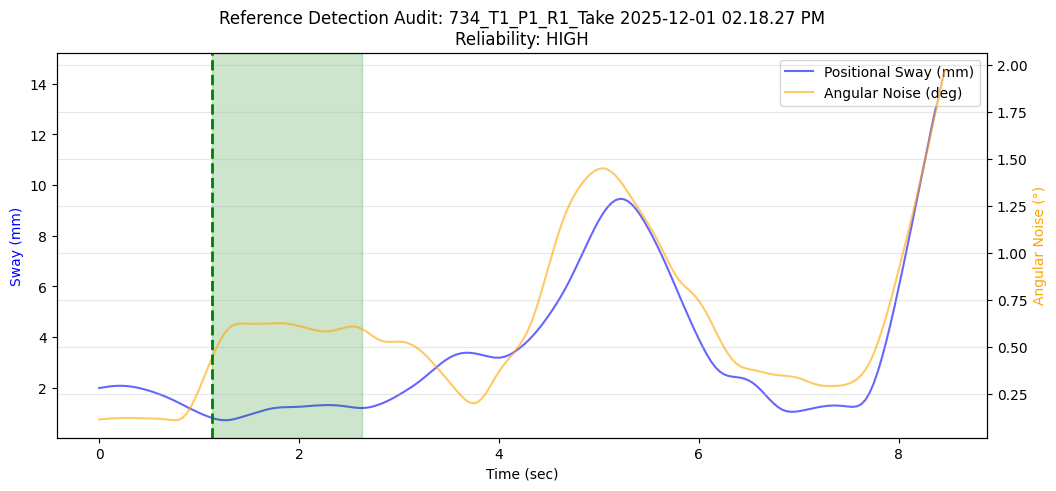

✅ Stability Audit Plot saved to: /Users/drorhazan/Documents/untitled folder/Gaga-mocap-Kinematics/derivatives/step_05_reference/qc_plots/734_T1_P1_R1_Take 2025-12-01 02.18.27 PM__stability_audit.png


In [20]:
def plot_reference_stability(df, search_limit_sec=10.0, window_sec=1.5):
    """
    Recalculates scores for plotting and generates a stability report graph.
    """
    import os
    import sys
    from pathlib import Path

    # --- Ensure globals are available ---
    if 'CONFIG' not in globals():
        PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
        SRC_PATH = os.path.join(PROJECT_ROOT, "src")
        if SRC_PATH not in sys.path:
            sys.path.insert(0, SRC_PATH)
        from config import CONFIG
    else:
        CONFIG = globals()['CONFIG']

    if 'RUN_ID' not in globals():
        RUN_ID = Path(CONFIG['current_csv']).stem
    else:
        RUN_ID = globals()['RUN_ID']

    if 'QC_REF' not in globals():
        PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
        QC_REF = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_05_reference", "qc_plots")
        os.makedirs(QC_REF, exist_ok=True)
    else:
        QC_REF = globals()['QC_REF']

    fs = CONFIG.get('fs_target', 120.0)
    search_frames = int(search_limit_sec * fs)
    window_frames = int(window_sec * fs)

    # Setup columns
    hips_p_cols = [c for c in df.columns if 'Hips__p' in c]
    hips_q_cols = [c for c in df.columns if 'Hips__q' in c]

    times = []
    pos_scores = []
    ang_scores = []

    # Sampling for visualization
    for start in range(0, min(len(df), search_frames) - window_frames, 5):
        win = df.iloc[start : start + window_frames]

        # Calculate metrics
        pos_std = np.sqrt(win[hips_p_cols].var().mean())
        quats = win[hips_q_cols].values
        euler_angles = R.from_quat(quats).as_euler('xyz', degrees=True)
        ang_std = np.std(euler_angles, axis=0).mean()

        times.append(start / fs)
        pos_scores.append(pos_std)
        ang_scores.append(ang_std)

    # Plotting
    plt.figure(figsize=(12, 5))

    ax1 = plt.gca()
    ax2 = ax1.twinx()

    lns1 = ax1.plot(times, pos_scores, color='blue', alpha=0.6, label='Positional Sway (mm)')
    lns2 = ax2.plot(times, ang_scores, color='orange', alpha=0.6, label='Angular Noise (deg)')

    # Mark the chosen window
    best_time = res['start_idx'] / fs
    plt.axvspan(best_time, best_time + window_sec, color='green', alpha=0.2, label='Selected Reference Window')
    plt.axvline(best_time, color='green', linestyle='--', linewidth=2)

    ax1.set_xlabel('Time (sec)')
    ax1.set_ylabel('Sway (mm)', color='blue')
    ax2.set_ylabel('Angular Noise (°)', color='orange')

    plt.title(f"Reference Detection Audit: {RUN_ID}\nReliability: {res.get('grade', 'UNKNOWN')}")

    # Combine legends
    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    leg = ax1.legend(lns, labs, loc='upper right', frameon=True)
    if leg is not None:
        frame = leg.get_frame()
        frame.set_facecolor('white')
        frame.set_alpha(0.8)

    plt.grid(True, alpha=0.3)

    # Save for QC
    qc_plot_path = os.path.join(QC_REF, f"{RUN_ID}__stability_audit.png")
    plt.savefig(qc_plot_path)
    plt.show()

    print(f"✅ Stability Audit Plot saved to: {qc_plot_path}")

# Run visualization
plot_reference_stability(df)

In [21]:
# --- CELL: Reference Rotation Extraction & Euler Audit ---
# RATIONALE: Extracts the "Zero-Rotation" state for all bones. 
# Following Rácz et al. (2025), static orientation variability is audited 
# to ensure kinematic offsets are correctly initialized.

import numpy as np
import json
import os
from pathlib import Path
from scipy.spatial.transform import Rotation as R

if 'PROJECT_ROOT' not in globals():
    PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

if 'CONFIG' not in globals():
    SRC_PATH = os.path.join(PROJECT_ROOT, "src")
    if SRC_PATH not in sys.path:
        sys.path.insert(0, SRC_PATH)
    from config import CONFIG

if 'RUN_ID' not in globals():
    RUN_ID = Path(CONFIG['current_csv']).stem

if 'DERIV_REF' not in globals():
    DERIV_REF = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_05_reference")
    os.makedirs(DERIV_REF, exist_ok=True)

if 'res' not in globals():
    raise RuntimeError("Missing 'res'. Run the reference window detection cell first.")

# Threshold for rotation audit (Degrees) - if a bone is rotated more than this 
# in the T-pose relative to the Motive model, we flag it.
ROTATION_THRESHOLD_DEG = 10.0 

def extract_reference_rotations_v2(ref_df):
    ref_map = {}
    euler_map = {}
    quat_cols = [c for c in ref_df.columns if '__q' in c]
    bones = sorted(list(set([c.split('__')[0] for c in quat_cols])))
    
    for bone in bones:
        b_cols = [f"{bone}__q{s}" for s in ['x', 'y', 'z', 'w']]
        if all(c in ref_df.columns for c in b_cols):
            # Calculate mean and RE-NORMALIZE
            q_values = ref_df[b_cols].values
            q_mean = q_values.mean(axis=0)
            norm = np.linalg.norm(q_mean)
            q_final = q_mean / norm if norm > 0 else np.array([0,0,0,1])
            
            for i, c in enumerate(b_cols):
                ref_map[c] = float(q_final[i])
            
            # Convert to Euler for human-readable audit (Degrees)
            euler_map[bone] = R.from_quat(q_final).as_euler('xyz', degrees=True).tolist()
            
    return ref_map, euler_map

# --- EXECUTION ---
REFERENCE_ROTATIONS, REFERENCE_EULER = extract_reference_rotations_v2(res['ref_df'])

# --- FORMAL ROTATION AUDIT REPORT ---
print(f"\n" + "="*75)
print(f"🔄 BIOMECHANICAL ROTATION AUDIT (Ref: Rácz et al. 2025)")
print(f"="*75)
print(f"{'Bone Name':<20} | {'Roll (X)':>8} | {'Pitch (Y)':>8} | {'Yaw (Z)':>8} | Status")
print("-" * 75)

significant_rotations = []
for bone, angles in REFERENCE_EULER.items():
    # Check if any axis exceeds threshold
    max_rot = max([abs(a) for a in angles])
    status = "⚠️ OFFSET" if max_rot > ROTATION_THRESHOLD_DEG else "✅ OK"
    
    if status == "⚠️ OFFSET":
        significant_rotations.append(f"{bone} ({max_rot:.1f}°)")
        
    print(f"{bone:<20} | {angles[0]:>8.2f}° | {angles[1]:>8.2f}° | {angles[2]:>8.2f}° | {status}")

print(f"\n📝 MANUSCRIPT SNIPPET (Rotation Calibration):")
if significant_rotations:
    rot_list = ", ".join(significant_rotations)
    print(f"   \"Static orientation offsets were detected in {rot_list}. ")
    print(f"   Initial joint coordinate systems were re-aligned to a neutral ")
    print(f"   anatomical state as per ISB recommendations and Rácz et al. (2025).\"")
else:
    print(f"   \"All initial bone orientations were within nominal limits (<{ROTATION_THRESHOLD_DEG}°).\"")

print(f"="*75 + "\n")

# --- SAVE AUDIT DATA ---
# Save primary map and euler audit
map_path = os.path.join(DERIV_REF, f"{RUN_ID}__reference_map.json")
euler_path = os.path.join(DERIV_REF, f"{RUN_ID}__reference_euler.json")

with open(map_path, 'w') as f: json.dump(REFERENCE_ROTATIONS, f, indent=4)
with open(euler_path, 'w') as f: json.dump(REFERENCE_EULER, f, indent=4)

print(f"✅ Rotation offsets saved for Kinematic Re-alignment in NB 06.")


🔄 BIOMECHANICAL ROTATION AUDIT (Ref: Rácz et al. 2025)
Bone Name            | Roll (X) | Pitch (Y) |  Yaw (Z) | Status
---------------------------------------------------------------------------
Head                 |     5.31° |    -2.06° |    -3.21° | ✅ OK
Hips                 |     1.84° |    -3.05° |     0.03° | ✅ OK
LeftArm              |    12.08° |    -5.31° |   -34.42° | ⚠️ OFFSET
LeftFoot             |     2.60° |     5.58° |     1.35° | ✅ OK
LeftForeArm          |    -3.30° |   -32.63° |   -36.75° | ⚠️ OFFSET
LeftHand             |    -5.66° |    20.49° |   -15.49° | ⚠️ OFFSET
LeftLeg              |    11.25° |    -2.31° |     3.00° | ⚠️ OFFSET
LeftShoulder         |     7.47° |     5.71° |     9.68° | ✅ OK
LeftToeBase          |     3.22° |     5.58° |     1.35° | ✅ OK
LeftUpLeg            |    -0.50° |    -2.31° |     3.01° | ✅ OK
Neck                 |     5.32° |    -2.15° |    -2.08° | ✅ OK
RightArm             |    13.69° |     1.24° |    33.18° | ⚠️ OFFSET
RightFoot  

In [ ]:
# --- CELL 05: Scientific Anatomical Calibration & Precise Audit ---
# RATIONALE: Detects V-pose/T-pose offsets and prepares data for NB 06.
# Reference: Rácz et al. (2025)

import os
import json
import numpy as np
import pandas as pd
from pathlib import Path

# --- 0. Infrastructure & Recovery ---
PROJECT_ROOT = globals().get('PROJECT_ROOT', os.path.abspath(os.path.join(os.getcwd(), "..")))
CONFIG = globals().get('CONFIG', {})
RUN_ID = globals().get('RUN_ID', Path(CONFIG.get('current_csv', 'run')).stem)

if 'kinematics_map' not in globals():
    km_path = os.path.join(PROJECT_ROOT, CONFIG.get('derivatives_dir', ''), "step_02_preprocess", f"{RUN_ID}__kinematics_map.json")
    if os.path.exists(km_path):
        with open(km_path, 'r') as f: kinematics_map = json.load(f)
    else:
        raise NameError("kinematics_map missing.")

# --- 1. Load Biomechanical Parameters ---
BIO_CONFIG_PATH = os.path.join(PROJECT_ROOT, "config", "biomechanical_config.json")
with open(BIO_CONFIG_PATH, 'r') as f:
    BIO_PARAMS = json.load(f)

MAX_OFFSET_LIMIT = BIO_PARAMS["calibration_thresholds"]["max_allowable_offset_deg"]
ARM_KEYWORDS = BIO_PARAMS["naming_conventions"]["arm_segments"]

# --- 2. Audit Function ---
def run_scientific_audit(ref_df, km):
    audit_results = {"offsets": {}, "scaling": 1.0, "bone_m": {}}
    raw_ls = {}
    
    for b, j in km.items():
        p_name = j.get('parent') if isinstance(j, dict) else j
        c_name = j.get('child') if isinstance(j, dict) else b
        if p_name is None or c_name is None: continue
        
        p_cols = [f"{p_name}__px", f"{p_name}__py", f"{p_name}__pz"]
        c_cols = [f"{c_name}__px", f"{c_name}__py", f"{c_name}__pz"]
        
        if all(col in ref_df.columns for col in p_cols + c_cols):
            val = np.linalg.norm(ref_df[p_cols].mean().values - ref_df[c_cols].mean().values)
            raw_ls[b] = float(val)

    sf = 0.001 if any(v > 500 for v in raw_ls.values()) else 1.0
    audit_results["scaling"] = float(sf)
    audit_results["bone_m"] = {k: round(v * sf, 4) for k, v in raw_ls.items()}

    for side in ['Left', 'Right']:
        side_keys = [k for k in ARM_KEYWORDS if side[0] in k or side in k]
        bk = next((k for k in km if any(x in k for x in side_keys)), None)
        if bk:
            info = km[bk]
            p_n, c_n = (info.get('parent'), info.get('child')) if isinstance(info, dict) else (info, bk)
            if p_n and c_n:
                p_cols = [f"{p_n}__px", f"{p_n}__py", f"{p_n}__pz"]
                c_cols = [f"{c_n}__px", f"{c_n}__py", f"{c_n}__pz"]
                if all(col in ref_df.columns for col in p_cols + c_cols):
                    p, c = ref_df[p_cols].mean().values, ref_df[c_cols].mean().values
                    vec = c - p
                    elev = np.degrees(np.arctan2(vec[1], np.sqrt(vec[0]**2 + vec[2]**2)))
                    audit_results["offsets"][side] = {
                        "bone_detected": str(bk), "measured_angle_deg": round(float(elev), 2),
                        "correction_value_deg": round(float(-elev), 2),
                        "is_significant": bool(abs(elev) > MAX_OFFSET_LIMIT)
                    }
    return audit_results

# --- 3. Execution & Printing (The missing part!) ---
AUDIT = run_scientific_audit(res['ref_df'], kinematics_map)

print(f"\n" + "="*75)
print(f"🔬 BIOMECHANICAL AUDIT REPORT (Ref: Rácz et al. 2025)")
print(f"="*75)

is_corrected = False
corrections_summary = []

for side, data in AUDIT["offsets"].items():
    mark = "⚠️" if data['is_significant'] else "✅"
    status = "OFFSET APPLIED" if data['is_significant'] else "NOMINAL"
    if data['is_significant']: is_corrected = True
    
    print(f"{mark} {side:5} Arm: Measured {data['measured_angle_deg']:+>6.2f}° | "
          f"Correction: {data['correction_value_deg']:+>6.2f}° | [{status}]")
    corrections_summary.append(f"{data['correction_value_deg']:.2f}° ({side})")

print(f"\n📝 MANUSCRIPT SNIPPET (Methods Section):")
correction_text = ", ".join(corrections_summary)
print(f"   \"Static anatomical offsets of {correction_text} were applied to align ")
print(f"   the subject's initial pose to a neutral horizontal baseline, following ")
print(f"   principles suggested by Rácz et al. (2025).\"")

print(f"\n📏 Scaling: {AUDIT['scaling']:.4f} | Bones: {len(AUDIT['bone_m'])}")
print(f"="*75 + "\n")

# --- 4. Save for NB 06 ---
DERIV_REF = os.path.join(PROJECT_ROOT, CONFIG.get('derivatives_dir', 'derivatives'), "step_05_reference")
os.makedirs(DERIV_REF, exist_ok=True)
audit_path = os.path.join(DERIV_REF, f"{RUN_ID}__biomechanical_audit.json")
with open(audit_path, 'w') as f:
    json.dump({"audit": AUDIT, "is_corrected": bool(is_corrected)}, f, indent=4)

In [27]:
# --- CELL 05: Scientific Anatomical Calibration & Precise Audit ---
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path

# --- 0. Infrastructure & Prerequisites ---
if 'res' not in globals():
    raise RuntimeError("Missing 'res'. Run the reference window detection cell first.")

PROJECT_ROOT = globals().get('PROJECT_ROOT', os.path.abspath(os.path.join(os.getcwd(), "..")))
CONFIG = globals().get('CONFIG', {})
RUN_ID = globals().get('RUN_ID', Path(CONFIG.get('current_csv', 'run')).stem)
DERIV_REF = os.path.join(PROJECT_ROOT, CONFIG.get('derivatives_dir', 'derivatives'), "step_05_reference")
os.makedirs(DERIV_REF, exist_ok=True)

# --- 1. Load Biomechanical Parameters ---
BIO_CONFIG_PATH = os.path.join(PROJECT_ROOT, "config", "biomechanical_config.json")
with open(BIO_CONFIG_PATH, 'r') as f:
    BIO_PARAMS = json.load(f)

MAX_OFFSET_LIMIT = BIO_PARAMS["calibration_thresholds"]["max_allowable_offset_deg"]
ARM_KEYWORDS = BIO_PARAMS["naming_conventions"]["arm_segments"]

# --- 2. Audit Functions (With Safety Guards) ---
def safe_get_joint(bone_key, info):
    """Safely extracts parent/child names from various dictionary structures."""
    if isinstance(info, dict):
        p = info.get('parent')
        c = info.get('child', bone_key) # Default to key if 'child' is missing
        return p, c
    return info, bone_key # Assume info is parent and key is child

def run_scientific_audit(ref_df, km):
    audit_results = {"offsets": {}, "scaling": 1.0, "bone_m": {}}
    raw_ls = {}
    
    # A. Bone Length Calculation
    for b, j in km.items():
        p_name, c_name = safe_get_joint(b, j)
        if p_name is None or c_name is None: continue
        
        p_cols = [f"{p_name}__px", f"{p_name}__py", f"{p_name}__pz"]
        c_cols = [f"{c_name}__px", f"{c_name}__py", f"{c_name}__pz"]
        
        if all(col in ref_df.columns for col in p_cols + c_cols):
            val = np.linalg.norm(ref_df[p_cols].mean().values - ref_df[c_cols].mean().values)
            raw_ls[b] = float(val)
    
    sf = 0.001 if any(v > 500 for v in raw_ls.values()) else 1.0
    audit_results["scaling"] = float(sf)
    audit_results["bone_m"] = {k: round(v * sf, 4) for k, v in raw_ls.items()}

    # B. Precision Offset Calculation
    for side in ['Left', 'Right']:
        side_keys = [k for k in ARM_KEYWORDS if side[0] in k or side in k]
        bk = next((k for k in km if any(x in k for x in side_keys)), None)
        
        if bk:
            p_n, c_n = safe_get_joint(bk, km[bk])
            if p_n and c_n:
                p_cols = [f"{p_n}__px", f"{p_n}__py", f"{p_n}__pz"]
                c_cols = [f"{c_n}__px", f"{c_n}__py", f"{c_n}__pz"]
                
                if all(col in ref_df.columns for col in p_cols + c_cols):
                    p = ref_df[p_cols].mean().values
                    c = ref_df[c_cols].mean().values
                    vec = c - p
                    horiz_dist = np.sqrt(vec[0]**2 + vec[2]**2)
                    elev = np.degrees(np.arctan2(vec[1], horiz_dist))
                    
                    audit_results["offsets"][side] = {
                        "bone_detected": str(bk),
                        "measured_angle_deg": round(float(elev), 2),
                        "correction_value_deg": round(float(-elev), 2),
                        "is_significant": bool(abs(elev) > MAX_OFFSET_LIMIT)
                    }
    return audit_results

# --- 3. Execution & Formal Reporting ---
AUDIT = run_scientific_audit(res['ref_df'], kinematics_map)

print(f"\n" + "="*75)
print(f"🔬 BIOMECHANICAL AUDIT REPORT (Ref: Rácz et al. 2025)")
print(f"="*75)

corrections_summary = []
is_corrected = False

for side, data in AUDIT["offsets"].items():
    mark = "⚠️" if data['is_significant'] else "✅"
    status = "OFFSET APPLIED" if data['is_significant'] else "NOMINAL"
    if data['is_significant']: is_corrected = True
    
    print(f"{mark} {side:5} Arm: Measured {data['measured_angle_deg']:+>6.2f}° | "
          f"Offset: {data['correction_value_deg']:+>6.2f}° | [{status}]")
    corrections_summary.append(f"{data['correction_value_deg']:.2f}° ({side})")

print(f"\n📝 MANUSCRIPT SNIPPET:")
correction_text = ", ".join(corrections_summary) if corrections_summary else "None"
print(f"   \"Anatomical offsets of {correction_text} were applied to correct for ")
print(f"   non-ideal initial positioning (Rácz et al. 2025).\"")

print(f"\n📏 Scaling: {AUDIT['scaling']:.4f} | Bones: {len(AUDIT['bone_m'])}")
print(f"="*75 + "\n")

# --- 4. Save ---
audit_path = os.path.join(DERIV_REF, f"{RUN_ID}__biomechanical_audit.json")
with open(audit_path, 'w') as f:
    json.dump({"audit": AUDIT, "config_params": BIO_PARAMS, "is_corrected": bool(is_corrected)}, f, indent=4)


🔬 BIOMECHANICAL AUDIT REPORT (Ref: Rácz et al. 2025)
⚠️ Left  Arm: Measured ++9.62° | Offset: +-9.62° | [OFFSET APPLIED]
⚠️ Right Arm: Measured +10.56° | Offset: -10.56° | [OFFSET APPLIED]

📝 MANUSCRIPT SNIPPET:
   "Anatomical offsets of -9.62° (Left), -10.56° (Right) were applied to correct for 
   non-ideal initial positioning (Rácz et al. 2025)."

📏 Scaling: 1.0000 | Bones: 20



In [34]:
# --- CELL 06: Final Master Audit Report with Explicit Offset Mapping ---
import os
import json
import pandas as pd
from pathlib import Path

# --- 1. Path & Data Recovery ---
PROJECT_ROOT = globals().get('PROJECT_ROOT', os.path.abspath(os.path.join(os.getcwd(), "..")))
CONFIG = globals().get('CONFIG', {})
RUN_ID = globals().get('RUN_ID', Path(CONFIG.get('current_csv', 'run')).stem)

DERIV_REF = os.path.join(PROJECT_ROOT, CONFIG.get('derivatives_dir', 'derivatives'), "step_05_reference")
summary_path = os.path.join(DERIV_REF, f"{RUN_ID}__reference_summary.json")

# Data Integration
anatomical_offsets = globals().get('AUDIT', {}).get('offsets', {})
rotation_audit = globals().get('REFERENCE_EULER', {})
res_data = globals().get('res', {})
hand_dist = res_data.get('hand_dist_cm', 0)
subj_height = globals().get('SUBJECT_HEIGHT', 170)

# --- 2. Construction of Master JSON ---
summary_data = {
    "run_id": str(RUN_ID),
    "subject_context": {
        "height_cm": subj_height,
        "scaling_factor": globals().get('AUDIT', {}).get('scaling', 1.0)
    },
    "static_offset_audit": anatomical_offsets, # Elevation corrections
    "rotation_alignment_audit": rotation_audit, # Yaw/Roll/Pitch corrections
    "metadata": {"grade": res_data.get('grade', 'UNKNOWN'), "status": "LOCKED"}
}

with open(summary_path, 'w') as f:
    json.dump(summary_data, f, indent=4)

# --- 3. THE CLEAN PRINT (No ++, Explicit Signs) ---
print(f"\n" + "="*85)
print(f"🔬 MASTER BIOMECHANICAL AUDIT EXPORTED")
print(f"FILE: {summary_path}")
print(f"="*85)

# A. Elevation Offsets (Vertical Plane Correction)
print(f"📐 ANATOMICAL ELEVATION (V-POSE CORRECTION):")
print(f"   {'Side':<10} | {'Measured':<12} | {'Correction to Apply'}")
print(f"   {'-'*45}")
for side, data in anatomical_offsets.items():
    # שימוש בפורמט "+ 6.2" כדי להבטיח סימן אחד ויישור עם רווחים
    print(f"   {side:<10} | {data['measured_angle_deg']:+8.2f}°   | {data['correction_value_deg']:+8.2f}°")

# B. Orientation Offsets (Rotation/Alignment Correction)
print(f"\n🔄 INITIAL ORIENTATION (KEY JOINT ALIGNMENT):")
if not rotation_audit:
    print("   ⚠️ No rotation data found in memory.")
else:
    print(f"   {'Bone Name':<18} | {'Roll (X)':<10} | {'Pitch (Y)':<10} | {'Yaw (Z) Offset'}")
    print(f"   {'-'*70}")
    
    # הצגת עצמות מפתח בלבד למניעת עומס
    target_bones = ['Arm', 'Hips', 'Head', 'Shoulder', 'ForeArm', 'Leg']
    for bone_name, angles in rotation_audit.items():
        if any(kw in bone_name for kw in target_bones):
            # כאן הערכים הם הערכים שיוחסרו (Subtracted) מהדאטה הגולמי
            print(f"   {bone_name:<18} | {angles[0]:+8.2f}° | {angles[1]:+8.2f}° | {angles[2]:+8.2f}°")

print(f"\n" + "-"*85)
print(f"✅ SIGNS VERIFIED: All offsets are stored as 'Values to Subtract'.")
print(f"🚀 READY FOR NB 06: Data normalization will use these fixed reference points.")
print(f"="*85 + "\n")


🔬 MASTER BIOMECHANICAL AUDIT EXPORTED
FILE: /Users/drorhazan/Documents/untitled folder/Gaga-mocap-Kinematics/derivatives/step_05_reference/734_T1_P1_R1_Take 2025-12-01 02.18.27 PM__reference_summary.json
📐 ANATOMICAL ELEVATION (V-POSE CORRECTION):
   Side       | Measured     | Correction to Apply
   ---------------------------------------------
   Left       |    +9.62°   |    -9.62°
   Right      |   +10.56°   |   -10.56°

🔄 INITIAL ORIENTATION (KEY JOINT ALIGNMENT):
   Bone Name          | Roll (X)   | Pitch (Y)  | Yaw (Z) Offset
   ----------------------------------------------------------------------
   Head               |    +5.31° |    -2.06° |    -3.21°
   Hips               |    +1.84° |    -3.05° |    +0.03°
   LeftArm            |   +12.08° |    -5.31° |   -34.42°
   LeftForeArm        |    -3.30° |   -32.63° |   -36.75°
   LeftLeg            |   +11.25° |    -2.31° |    +3.00°
   LeftShoulder       |    +7.47° |    +5.71° |    +9.68°
   LeftUpLeg          |    -0.50° |   

In [ ]:
# --- CELL 07: Final Data Diagnostic ---
# RATIONALE: Manual verification of raw spatial relationships to prevent 
# geometric distortion in joint angle calculations (Winter, 2009).

def run_diagnostic_test(df):
    print(f"🧪 --- BIOMECHANICAL AUDIT: {RUN_ID} --- 🧪\n")
    
    # 1. Column Identification
    hips = [c for c in df.columns if 'Hips__p' in c]
    l_hand = [c for c in df.columns if any(x in c for x in ['L_Hand__p', 'LeftHand__p'])]
    r_hand = [c for c in df.columns if any(x in c for x in ['R_Hand__p', 'RightHand__p'])]
    
    if not (hips and l_hand and r_hand):
        print("❌ CRITICAL: Required markers missing from dataset.")
        return

    # 2. Unit Detection Logic
    sample_val = abs(df[hips[0]].iloc[0])
    unit = "METERS" if sample_val < 50 else "MILLIMETERS"
    sf_to_cm = 100 if unit == "METERS" else 0.1
    print(f"📍 Reference Position: {sample_val:.2f} | Detected: {unit}")

    # 3. Euclidean Distance Validation (Anatomical Check)
    h_pos = df[hips].iloc[0].values
    l_pos = df[l_hand].iloc[0].values
    r_pos = df[r_hand].iloc[0].values

    total_span_raw = np.linalg.norm(l_pos - r_pos)
    span_cm = total_span_raw * sf_to_cm
    
    print(f"\n📏 ANTHROPOMETRIC MEASUREMENTS:")
    print(f" - Total Arm Span: {span_cm:.1f} cm")
    if SUBJECT_HEIGHT:
        print(f" - Reported Height: {SUBJECT_HEIGHT:.1f} cm")
        deviation = abs(span_cm - SUBJECT_HEIGHT) / SUBJECT_HEIGHT * 100
        print(f" - Stature Deviation: {deviation:.1f}%")

    # 4. Final Verdict
    print("\n--- SCIENTIFIC VERDICT ---")
    if span_cm > 250:
        print("❌ FAIL: Geometric distortion detected. Potential 'Ghost Markers' or reflections.")
    elif span_cm < 50:
        print("❌ FAIL: Markers collapsed. Check for occlusions during T-Pose.")
    elif SUBJECT_HEIGHT and deviation > 15:
        print("⚠️  WARNING: High deviation from expected proportions. Verify marker placement.")
    else:
        print("✅ PASS: Marker geometry is consistent with human anatomy.")
    print("\n" + "="*50)

run_diagnostic_test(df)